Solving https://www.lesswrong.com/posts/ycG3mrtdqddCkK9et/d-and-d-sci-pathfinder-return-of-the-gray-swan.

In [32]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
url = "https://raw.githubusercontent.com/aphyer1992/dndsci-pathfinder/main/dndsci_pathfinder_player_voyage_log.csv"
trip = pd.read_csv(url,index_col=0)
trip.columns = ['Origin','Date','Route','ShipID','ShipName','ShipType','CapName','RepairTime','Destination','Purpose','Damage']
url2 = "https://raw.githubusercontent.com/aphyer1992/dndsci-pathfinder/main/dndsci_pathfinder_player_encounter_log.csv"
enc = pd.read_csv(url2)
enc.columns = ['VoyID','ShipID','ShipName','Hex','Type','Damage']

This is quite a lot of data, and so I will plan how to analyse it, instead of just blundering in.

Step 0: Data cleanup; rename columns so titles are all valid Python identifiers, strip % signs, attach ship types to table 2, etc.

Step 1: Identify how likely encounters are on various hexes.  
To do this, I need count, for each hex a ship goes through, both the number of times the hex was visited, and the encounter breakdown of the hex. For now, I ignore time trends. 

Step 2: Identify how dangerous encounters are by amount of damage they deal, based on ship type (and maybe some captaincy benefits if time). 

Step 3: Go through paths of destroyed ships, and use this to improve estimation in Step 2.

Step 4: Black Swan Checking (i.e. is there a hex with no known encounters because every ship that went there sank).


Step 5: Identify some candidate paths to my target hexes, and work out which ship-path combinations are best.

Step 6: Pray the ship I want is available; try to pick ones that (i) took less damage on previous voyage, (ii) have been in port for longer, (iii) have good captains [by lower-than-expected damage per encounter].

In [33]:
shipTypes = []
for x in range(len(enc.VoyID)):
    t = trip.loc[enc.VoyID[x]].ShipType
    shipTypes.append(t)

In [34]:
enc['ShipType'] = shipTypes

In [35]:
enc['Damage'] = enc['Damage'].str.rstrip("%").astype(float)

In [36]:
trip['Damage'] = trip['Damage'].replace(['Destroyed'], np.nan)
trip['Damage'] = trip['Damage'].str.rstrip("%").astype(float)

In [7]:
print(trip)

                          Origin                 Date  \
Voyage ID                                               
1          Hex P15 (South Point)  January 1407 Week 1   
2          Hex P15 (South Point)  January 1407 Week 1   
3          Hex P15 (South Point)  January 1407 Week 1   
4           Hex G13 (Westengard)  January 1407 Week 1   
5           Hex G13 (Westengard)  January 1407 Week 1   
...                          ...                  ...   
6666       Hex P15 (South Point)     June 1420 Week 1   
6667        Hex G13 (Westengard)     June 1420 Week 1   
6668        Hex G13 (Westengard)     June 1420 Week 1   
6669        Hex G13 (Westengard)     June 1420 Week 1   
6670           Hex I3 (Norwatch)     June 1420 Week 1   

                                                       Route  ShipID  \
Voyage ID                                                              
1                        P15-Q14-Q13-Q12-P11-Q12-P13-Q14-P15      55   
2                                P15-Q14-Q

In [8]:
print(enc)

       VoyID  ShipID        ShipName      Hex     Type  Damage     ShipType
0          1      55    Scurvy Goose  Hex P11    Storm     7.0      Galleon
1          1      55    Scurvy Goose  Hex Q12  Harpies     0.0      Galleon
2          1      55    Scurvy Goose  Hex P13    Storm     7.0      Galleon
3          1      55    Scurvy Goose  Hex Q14  Pirates     0.0      Galleon
4          3      18       Gray Swan  Hex O14  Harpies     0.0      Galleon
...      ...     ...             ...      ...      ...     ...          ...
17239   6669     652  Scurvy Diamond  Hex H13   Sharks     0.0      Carrack
17240   6669     652  Scurvy Diamond  Hex I14    Storm    20.0      Carrack
17241   6670     697    Golden Pearl   Hex J5  Harpies    10.0  Barquentine
17242   6670     697    Golden Pearl   Hex J6  Pirates    20.0  Barquentine
17243   6670     697    Golden Pearl   Hex I9    Storm    25.0  Barquentine

[17244 rows x 7 columns]


In [37]:
enc['Hex'] = enc['Hex'].str[4:]

In [38]:
def getEncounterRate(eType,trip,enc):
    enc = enc[enc.Type == eType]
    t = trip[~(np.isnan(trip.Damage))].Route.str.split('-').sum()
    visits = Counter(t)
    visits.most_common()
    hexEncs = enc['Hex'].value_counts()
    for Hex in visits:
        try:
            if visits[Hex] < 7:
                visits[Hex] = np.nan
            else:
                visits[Hex] = hexEncs.loc[Hex]/visits[Hex]
        except KeyError:
            visits[Hex] = 0
    return visits.most_common()

I can now obtain Step 1 data. I now generate and analyse the results for each encounter type.

In [39]:
getEncounterRate('Storm',trip,enc)

[('S8', 0.15384615384615385),
 ('M6', 0.15306122448979592),
 ('F14', 0.14925373134328357),
 ('E15', 0.14516129032258066),
 ('N9', 0.11764705882352941),
 ('F9', 0.11382113821138211),
 ('K1', 0.10752688172043011),
 ('J16', 0.10526315789473684),
 ('N3', 0.1),
 ('G14', 0.08904109589041095),
 ('Q10', 0.0889487870619946),
 ('P3', 0.08860759493670886),
 ('F15', 0.08823529411764706),
 ('J11', 0.08602150537634409),
 ('H4', 0.08411214953271028),
 ('O2', 0.08333333333333333),
 ('J10', 0.08333333333333333),
 ('L8', 0.08284023668639054),
 ('O3', 0.08),
 ('E10', 0.07894736842105263),
 ('N14', 0.07848101265822785),
 ('L5', 0.0782312925170068),
 ('L15', 0.07611548556430446),
 ('N4', 0.07575757575757576),
 ('M3', 0.07407407407407407),
 ('K10', 0.07228915662650602),
 ('E4', 0.07142857142857142),
 ('P9', 0.06936416184971098),
 ('P8', 0.06910569105691057),
 ('R3', 0.06896551724137931),
 ('K15', 0.0683453237410072),
 ('I9', 0.06818181818181818),
 ('F13', 0.06766917293233082),
 ('S10', 0.0625),
 ('M16', 0.0

5 to 15% chance of finding a Storm in any hex; looks basically random (note the nontrivial variance is consistent with chance of finding a Storm being constant across all hexes, since we have a lot of hexes).

Note this only considers ships that survive storms; the true likelyhood of a storm is probably slightly higher than 10% on average.

In [40]:
getEncounterRate('Harpies',trip,enc)

[('M1', 0.15384615384615385),
 ('E1', 0.15384615384615385),
 ('O1', 0.13333333333333333),
 ('D11', 0.12903225806451613),
 ('S13', 0.1111111111111111),
 ('S9', 0.1111111111111111),
 ('E5', nan),
 ('F16', 0.1111111111111111),
 ('E8', 0.1),
 ('D16', 0.1),
 ('Q7', 0.09523809523809523),
 ('F12', 0.09278350515463918),
 ('N16', 0.09090909090909091),
 ('L12', 0.09090909090909091),
 ('C12', 0.09090909090909091),
 ('C15', 0.09090909090909091),
 ('I14', 0.0896551724137931),
 ('G10', 0.08947368421052632),
 ('K14', 0.08936170212765958),
 ('G11', 0.08852459016393442),
 ('G4', 0.0873015873015873),
 ('N4', 0.08484848484848485),
 ('H13', 0.08370837083708371),
 ('R10', 0.08108108108108109),
 ('H10', 0.08070175438596491),
 ('S7', 0.08),
 ('N5', 0.07942238267148015),
 ('K15', 0.07913669064748201),
 ('O4', 0.07801418439716312),
 ('S8', 0.07692307692307693),
 ('H0', 0.07692307692307693),
 ('E12', 0.07692307692307693),
 ('F7', 0.07692307692307693),
 ('L14', 0.07653061224489796),
 ('L15', 0.07611548556430446)

Harpies are similar to Storms; no real obvious patterns.

In [42]:
getEncounterRate('Pirates',trip,enc)

[('M1', 0.15384615384615385),
 ('M3', 0.14814814814814814),
 ('S5', 0.14285714285714285),
 ('O1', 0.13333333333333333),
 ('P16', 0.11538461538461539),
 ('L1', 0.1111111111111111),
 ('S13', 0.1111111111111111),
 ('J16', 0.10526315789473684),
 ('N3', 0.1),
 ('F4', 0.1),
 ('K10', 0.0963855421686747),
 ('R4', 0.09574468085106383),
 ('S10', 0.09375),
 ('J9', 0.09345794392523364),
 ('N16', 0.09090909090909091),
 ('P8', 0.08943089430894309),
 ('K8', 0.088),
 ('M7', 0.08629441624365482),
 ('F15', 0.0784313725490196),
 ('R3', 0.07758620689655173),
 ('Q4', 0.07692307692307693),
 ('K9', 0.07647058823529412),
 ('L15', 0.07611548556430446),
 ('K15', 0.07553956834532374),
 ('K1', 0.07526881720430108),
 ('F9', 0.07317073170731707),
 ('K2', 0.07042253521126761),
 ('N4', 0.06363636363636363),
 ('S2', 0.0625),
 ('Q3', 0.0625),
 ('L9', 0.061855670103092786),
 ('G14', 0.06164383561643835),
 ('L5', 0.061224489795918366),
 ('O3', 0.06),
 ('M16', 0.058823529411764705),
 ('N9', 0.058823529411764705),
 ('P9', 

Pirates similar.

In [44]:
getEncounterRate('Reef',trip,enc)

[('D10', 0.4),
 ('S8', 0.38461538461538464),
 ('K16', 0.35714285714285715),
 ('Q9', 0.3108108108108108),
 ('Q8', 0.2941952506596306),
 ('R9', 0.2641509433962264),
 ('C11', 0.25),
 ('M11', 0.24561403508771928),
 ('I15', 0.23809523809523808),
 ('I7', 0.23552123552123552),
 ('N10', 0.21666666666666667),
 ('L10', 0.21495327102803738),
 ('G4', 0.21428571428571427),
 ('J16', 0.21052631578947367),
 ('L9', 0.20618556701030927),
 ('O12', 0.20270270270270271),
 ('I8', 0.20170454545454544),
 ('S7', 0.2),
 ('R2', 0.2),
 ('R1', 0.2),
 ('C13', 0.19736842105263158),
 ('O10', 0.18691588785046728),
 ('N13', 0.18571428571428572),
 ('K8', 0.184),
 ('P1', 0.18181818181818182),
 ('N8', 0.18072289156626506),
 ('O14', 0.1795774647887324),
 ('P9', 0.1791907514450867),
 ('P8', 0.17886178861788618),
 ('M4', 0.17787418655097614),
 ('L1', 0.17777777777777778),
 ('J9', 0.17757009345794392),
 ('N7', 0.17613636363636365),
 ('L15', 0.1732283464566929),
 ('G2', 0.17073170731707318),
 ('I14', 0.16551724137931034),
 ('M

Ahh, real patterns. Every occurence of reef* is adjacent to land, but not adjacent to a port. I can avoid reefs moderately effectively. Also, every valid square adjacent to R8 is in the top 6 of the list; maybe avoid those squares too.

This data will be more valuable if certain ships can/can't deal with reef very well; I can choose routes with more/less reef based on how damaging it is.

*There is an island on I16 that is not on the map

In [45]:
getEncounterRate('Kraken',trip,enc)

[('E2', 0.4666666666666667),
 ('L7', 0.3942307692307692),
 ('K12', 0.38271604938271603),
 ('E11', 0.36764705882352944),
 ('G6', 0.33962264150943394),
 ('I11', 0.3393939393939394),
 ('H10', 0.3263157894736842),
 ('S16', 0.32),
 ('J12', 0.30708661417322836),
 ('H6', 0.2924281984334204),
 ('F9', 0.2845528455284553),
 ('O3', 0.28),
 ('K13', 0.27844311377245506),
 ('S13', 0.2777777777777778),
 ('L13', 0.27547169811320754),
 ('F0', 0.2727272727272727),
 ('O4', 0.2695035460992908),
 ('M6', 0.2687074829931973),
 ('G10', 0.26842105263157895),
 ('R11', 0.26737967914438504),
 ('N5', 0.26714801444043323),
 ('G8', 0.2578616352201258),
 ('J13', 0.25614754098360654),
 ('R13', 0.25274725274725274),
 ('G7', 0.252),
 ('L6', 0.25142857142857145),
 ('F10', 0.24390243902439024),
 ('E1', 0.23076923076923078),
 ('R12', 0.22802197802197802),
 ('J11', 0.22580645161290322),
 ('Q11', 0.22514619883040934),
 ('S15', 0.21052631578947367),
 ('F8', 0.2),
 ('E9', 0.18604651162790697),
 ('S3', 0.17647058823529413),
 ('

Every occurence of Kraken is distance at least 3 from land. 

In [46]:
getEncounterRate('Sharks',trip,enc)

[('E1', 0.23076923076923078),
 ('B13', 0.2),
 ('F7', 0.15384615384615385),
 ('D9', 0.125),
 ('M12', 0.12371134020618557),
 ('K11', 0.12195121951219512),
 ('Q2', 0.10526315789473684),
 ('D10', 0.1),
 ('N1', 0.1),
 ('E5', nan),
 ('E8', 0.2),
 ('J11', 0.1935483870967742),
 ('S3', 0.17647058823529413),
 ('L7', 0.16346153846153846),
 ('S7', 0.16),
 ('S11', 0.16),
 ('M6', 0.14965986394557823),
 ('S14', 0.14705882352941177),
 ('H6', 0.1409921671018277),
 ('G7', 0.136),
 ('G9', 0.1329479768786127),
 ('G6', 0.1320754716981132),
 ('E10', 0.13157894736842105),
 ('D11', 0.12903225806451613),
 ('Q11', 0.1286549707602339),
 ('O4', 0.1276595744680851),
 ('N5', 0.11913357400722022),
 ('J13', 0.11475409836065574),
 ('H10', 0.10877192982456141),
 ('K10', 0.10843373493975904),
 ('G1', 0.10666666666666667),
 ('G10', 0.10526315789473684),
 ('G5', 0.10526315789473684),
 ('S12', 0.1),
 ('D16', 0.1),
 ('R13', 0.0989010989010989),
 ('F9', 0.0975609756097561),
 ('E15', 0.0967741935483871),
 ('R11', 0.0962566844

More variance than Storms and Harpies; something might be going on, but nothing as obvious as Reef or Kraken.

In [47]:
getEncounterRate('Dragon',trip,enc)

[('G15', 0.16666666666666666),
 ('E5', nan),
 ('C14', 0.08333333333333333),
 ('F7', 0.07692307692307693),
 ('O2', 0.05555555555555555),
 ('Q2', 0.05263157894736842),
 ('E14', 0.044444444444444446),
 ('G5', 0.042105263157894736),
 ('S12', 0.04),
 ('D11', 0.03225806451612903),
 ('S10', 0.03125),
 ('F5', 0.03125),
 ('H7', 0.0273972602739726),
 ('N11', 0.02702702702702703),
 ('O12', 0.02702702702702703),
 ('E10', 0.02631578947368421),
 ('H0', 0.02564102564102564),
 ('F11', 0.02459016393442623),
 ('F9', 0.024390243902439025),
 ('J11', 0.021505376344086023),
 ('N6', 0.02132701421800948),
 ('L9', 0.020618556701030927),
 ('M12', 0.020618556701030927),
 ('E12', 0.019230769230769232),
 ('G8', 0.018867924528301886),
 ('G6', 0.018867924528301886),
 ('P2', 0.01818181818181818),
 ('I9', 0.01818181818181818),
 ('K15', 0.017985611510791366),
 ('I5', 0.017391304347826087),
 ('D13', 0.017094017094017096),
 ('N7', 0.017045454545454544),
 ('K3', 0.016286644951140065),
 ('G2', 0.016260162601626018),
 ('J12

Either Dragons are rare, or they're good at killing ships so they seem rare. No real pattern in location though

In [48]:
getEncounterRate('Iceberg',trip,enc)

[('N1', 0.2),
 ('O2', 0.1111111111111111),
 ('K2', 0.09859154929577464),
 ('G2', 0.0975609756097561),
 ('F0', 0.09090909090909091),
 ('S8', 0.07692307692307693),
 ('E4', 0.07142857142857142),
 ('J2', 0.06976744186046512),
 ('O1', 0.06666666666666667),
 ('F4', 0.06666666666666667),
 ('F6', 0.06666666666666667),
 ('R2', 0.06666666666666667),
 ('E3', 0.0625),
 ('L0', 0.0625),
 ('K1', 0.053763440860215055),
 ('G1', 0.05333333333333334),
 ('H0', 0.05128205128205128),
 ('N3', 0.05),
 ('I2', 0.047619047619047616),
 ('K4', 0.04716981132075472),
 ('F1', 0.046511627906976744),
 ('J3', 0.0457516339869281),
 ('F3', 0.045454545454545456),
 ('H1', 0.04504504504504504),
 ('H2', 0.0449438202247191),
 ('R3', 0.04310344827586207),
 ('L4', 0.0426179604261796),
 ('G0', 0.041666666666666664),
 ('P5', 0.041015625),
 ('L5', 0.04081632653061224),
 ('G4', 0.03968253968253968),
 ('P6', 0.037460978147762745),
 ('R4', 0.03723404255319149),
 ('M3', 0.037037037037037035),
 ('O5', 0.0364741641337386),
 ('J4', 0.0363

Eyeballing just the number part of the co-ordinate yields that icebergs look more likely when ships are closer to the top. This is hardly surprising. I can probably ignore the effects of icebergs if I stay below height 2/3 on the map.

getEncounterRate('Merfolk',trip,enc)

There is a pod of Merfolk around E15 which I can ignore, since I'm not going near there. Every other Merfolk encounter is within distance 1 of triangle (F5,J13,N5).

I think about whether the "other" Merfolk encounters are occur at random, or due to contact with a migrating pod. Priors point towards migrating pod, since if these Merfolk are defending some fixed territory, the territory has a giant hole in the middle of it.

My last few Merfolk encounters in reverse order are at: (H4,G4;H5;M6;M4;M5;O6;L10). Looks like a mobile pod, but I'm not really certain where they are today. Perhaps 80% confidence that they are on the F5-J13 line somewhere.

In [50]:
getEncounterRate('Wyrd Majick Fyre',trip,enc)

[('I9', 0.17727272727272728),
 ('K8', 0.168),
 ('J7', 0.15555555555555556),
 ('I8', 0.1534090909090909),
 ('J9', 0.1308411214953271),
 ('I7', 0.12355212355212356),
 ('P1', 0.09090909090909091),
 ('Q2', 0.05263157894736842),
 ('Q3', 0.015625),
 ('E11', 0.014705882352941176),
 ('L11', 0.00909090909090909),
 ('I15', 0.006802721088435374),
 ('K3', 0.006514657980456026),
 ('H2', 0.0056179775280898875),
 ('R11', 0.0053475935828877),
 ('I12', 0.004761904761904762),
 ('H7', 0.0045662100456621),
 ('G7', 0.004),
 ('K5', 0.003968253968253968),
 ('K15', 0.0035971223021582736),
 ('J14', 0.0035460992907801418),
 ('O11', 0.0034965034965034965),
 ('J6', 0.003401360544217687),
 ('L5', 0.003401360544217687),
 ('P10', 0.003367003367003367),
 ('G11', 0.003278688524590164),
 ('J3', 0.0032679738562091504),
 ('O5', 0.00303951367781155),
 ('L15', 0.0026246719160104987),
 ('Q12', 0.0021645021645021645),
 ('P9', 0.0019267822736030828),
 ('O14', 0.0017605633802816902),
 ('H11', 0.001610305958132045),
 ('I13', 0.

No way is this a single effect. Around island J8, it happens loads. Everywhere else it seems pretty unpredictable. I reckon these are two unrelated phenomena that both look firey. Avoid going close to J8, otherwise ignore.

Now, a function to plot the damage of an encounter, for all ships at once.

In [103]:
def getEncounterDamage(eType,trip,enc,sType='All',m=100):
    t = enc[enc.Type == eType]
    s1 = t[t.ShipType == 'Dhow']
    s2 = t[t.ShipType == 'Galleon']
    s3 = t[t.ShipType == 'Carrack']
    s4 = t[t.ShipType == 'Barquentine']
    
    if sType=='All':
        bins = np.linspace(0,m,20)
        plt.hist([s1['Damage'].tolist(),s2['Damage'].tolist(),s3['Damage'].tolist(),s4['Damage'].tolist()],bins,label=['Dhow', 'Galleon','Carrack','Barquentine'])
    elif sType =='Dhow':
        bins = range(100)
        plt.hist(s1['Damage'].tolist(),bins,label = ['Dhow'])
    elif sType =='Galleon':
        bins = range(100)
        plt.hist(s2['Damage'].tolist(),bins,label = ['Galleon'])
    elif sType =='Carrack':
        bins = range(100)
        plt.hist(s3['Damage'].tolist(),bins,label = ['Carrack'])
    elif sType =='Barquentine':
        bins = range(100)
        plt.hist(s4['Damage'].tolist(),bins,label = ['Barquentine'])
    plt.legend(loc='upper right')
    plt.show()

And now, 10 more graphs, analysing each encounter from the perspective of how much damage they do. Note 

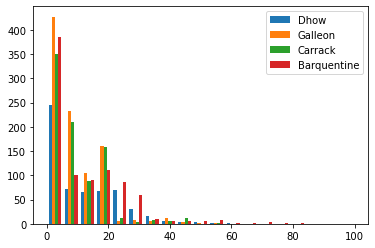

In [105]:
getEncounterDamage('Storm',trip,enc)

Generally low damage. Dhows fair better than average, Barquentines fair worse.

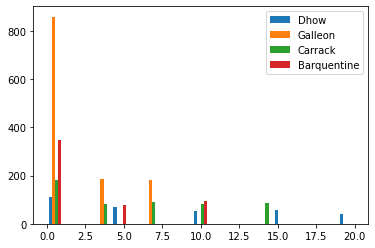

In [97]:
getEncounterDamage('Harpies',trip,enc,20)

Inconsequential damage. Note I have rescaled the x-axis. Note that Galleons have a lot more Harpy encounters than any other type of ship (even if normalising by the Storm encounter count)

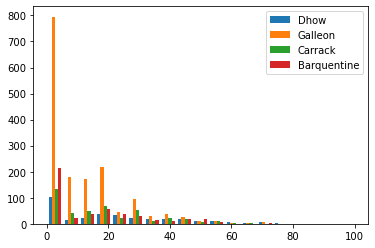

In [98]:
getEncounterDamage('Pirates',trip,enc)

Galleon damage is usually 0, often <2, with short tail. For the other types, I make more graphs.

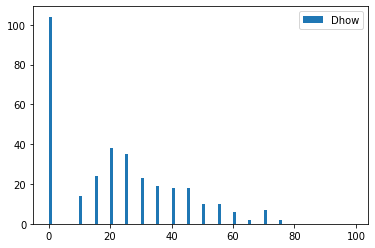

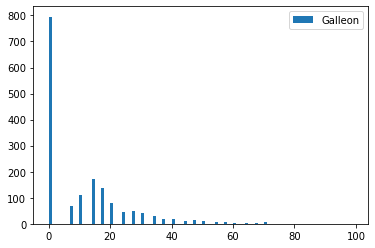

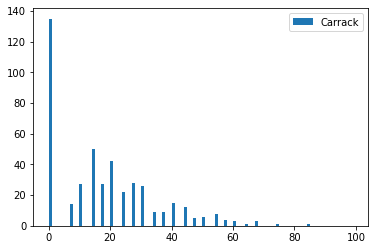

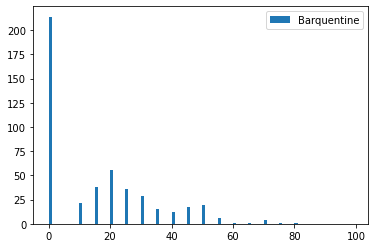

In [107]:
getEncounterDamage('Pirates',trip,enc,'Dhow')
getEncounterDamage('Pirates',trip,enc,'Galleon')
getEncounterDamage('Pirates',trip,enc,'Carrack')
getEncounterDamage('Pirates',trip,enc,'Barquentine')

This is interesting. Most pirate fights result in 0 damage. Then, we have an initial peak of damage (mental picture is of a brief skirmish) at 20% for Barquentines and Dhows, and at 14% for Carracks and Galleons. I reckon ships have an HP stat, and I reckon Carracks and Galleons have 50% more HP than Barquentines and Dhows.

Now, Barquentines are less likely to take damage than Dhows, and have a thinner tail. Galleons are less likely to take damage than Carracks, and have a thinner tail; Barquentines and Galleons are likely better at killing than the other two ships.

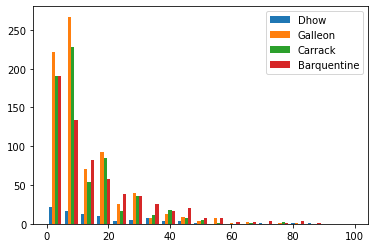

In [108]:
getEncounterDamage('Reef',trip,enc)

Reef damage is small but nontrivial and looks constant across ship types that are not Dhow (i.e. Barquentines are worse)
Dhows take just as much damage from Reef, but usually avoid them.

Remember that Reefs only exist in "shallow" water that is not next to a port.

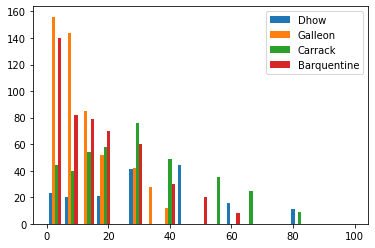

In [110]:
getEncounterDamage('Kraken',trip,enc)

Ok, Kraken are absolutely terrifying for Dhows and Carracks (which are worse at killing), with bearable damage for Galleons and Barquentines.

Remember that Kraken only fight in "deep" water - avoid

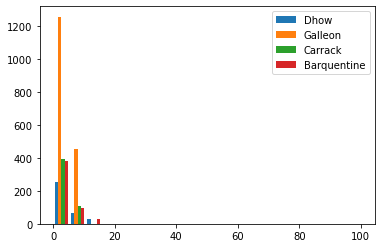

In [111]:
getEncounterDamage('Sharks',trip,enc)

Sharks don't do enough damage for me to want to spend time analysing this

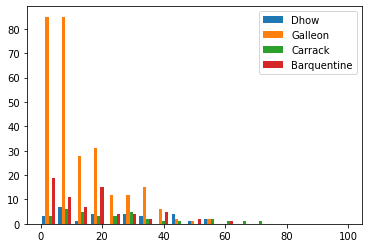

In [112]:
getEncounterDamage('Dragon',trip,enc)

I need to split this one up into constituent ships. 

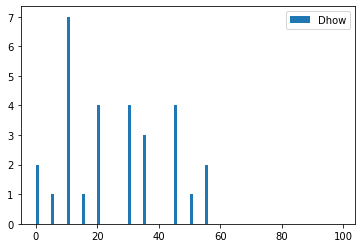

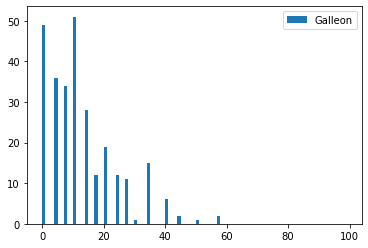

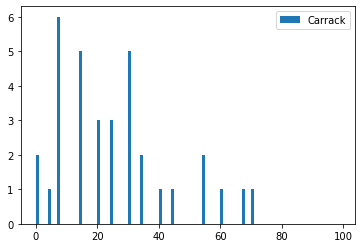

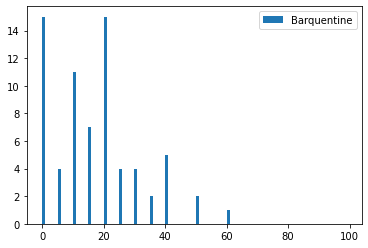

In [114]:
getEncounterDamage('Dragon',trip,enc,'Dhow')
getEncounterDamage('Dragon',trip,enc,'Galleon')
getEncounterDamage('Dragon',trip,enc,'Carrack')
getEncounterDamage('Dragon',trip,enc,'Barquentine')

Ah. Carracks and Dhows seem to have very few encounters with Dragons. This is going to be because Dragons murder them. They are also a moderate threat to Barquentines and Galleons (but Galleons have 50% more HP, so take less damage).

Icebergs I ignore; I don't think I'll hit them

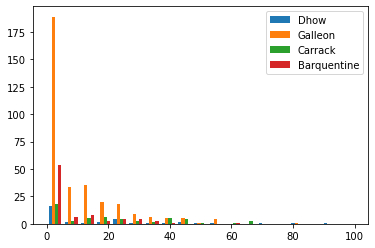

In [115]:
getEncounterDamage('Merfolk',trip,enc)

Merfolk don't look particularly dangerous either. Again, the ships that are better at killing are better at killing.

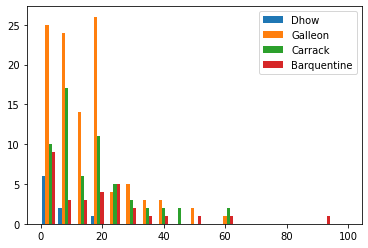

In [116]:
getEncounterDamage('Wyrd Majick Fyre',trip,enc)

I reckon the entire tail is from encounters around island J8. They'll be fine

So, now skipping straight to Step 5; if I have multiple very similar candidate paths, I may use Steps 3 and 4 to decide between them.

My route to E8 is long and avoids Reefs entirely. I am hence most worried about attritional damage from Sharks/Dragons/Storms/Harpies due to the sheer length. My options are Galleon and Barquentine. I think Barquentines probably have some sort of advantage due to their lower HP, and so will send a Barquentine.

The shortest possible route seems good, but goes through 2 hexes of deep water. I can avoid Kraken entirely by taking a path Q6-N6-M5-F5-E8. I want to do it in a Barquentine, but will check ship lists later.

My route to L13 will have 4 Reefs (unless I go a very long way around; seems bad, as Reefs aren't that terrible). This means I care more about HP and less about everything else; Galleon or Carrack seems better, but I'll choose Galleon since they're better above.

The shortest possible route, avoiding Q8 since the reef there is especially bad, is Q6-P8-P9-O11-N11-N13-M13. I want to do it in a Galleon.

"Standard Admiralty Practice" would be to assign The Bloody Diamond (a Barquentine) and The Orange Falcon (a Galleon) to these voyages. I do that - they've been in port the longest.

[Note to self; maybe return to this in a few weeks to try to improve it?]